# Tensor Flow Notebook
## W207 Final Project
### T. P. Goter
### July 15, 2019

This workbook is used to create convolutional neural nets for facial keypoint detection on CPUs (not TPUs).

In [1]:
# Import needed packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras import optimizers, metrics
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
tf.__version__
tf.keras.backend.clear_session()

## Data Loading

- Load in the pickle file that was created as part of the EDA in DataExploration.ipynb. 
- This dataset has the NaNs removed and a few mislabeled images removed as well. 
- As such there is only limited training and development data to use. 
- The image data has already been normalized to [0,1]

In [3]:
# Initialize Random Seed for reproducibility
np.random.seed(13)

# Load the dataframe from the pickle file
df_nostache_nonan = pd.read_pickle("df_nostache_nonan.pkl")

# Grab the last column - that is our image data for X matrix
X = df_nostache_nonan.iloc[:, -1]

# Convert from a series of arrays to an NDarray
X = np.array([x.reshape(96,96,1) for x in X])

# Grab the keypoints and stick into our y-variable
y = np.array(df_nostache_nonan.iloc[:,:-1])
# y = (y - 48) / 48  # scale target coordinates to [-1, 1]

In [4]:
X.shape

(2140, 96, 96, 1)

## Baseline Neural Net
CNNs are combinations of convolution layers, pooling layers and dropout layers followed by one or two fully connected layers once the number of dimensions has been sufficiently reduced.

1. Let's include just one hidden layer and one output layer
2. The input layer will reduce our flattened 96x96 matrix (i.e., 9216 in length) to a predetermined number of hidden units
3. We will then run sensitivities to # of hidden units, activation, optimizer, and learning rate
4. We will judge our model based on RMSE error and run time.

In [5]:
def create_cnn_model():
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
  
    return cnn_model
   
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
def create_bad_cnn_model():
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('relu'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
  
    return cnn_model

#### Define our optimizers for our initial study

In [12]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

opt_list = {'adam':adam,'sgd':sgd, 'nadam':nadam, 'adagrad':adagrad}
#opt_list = {'adam':adam}

#### Set up our first DOE

In [ ]:
time_callback = TimeHistory()
cnn_base_df = pd.DataFrame()
for opt_name, opt in opt_list.items():
    model = create_cnn_model()
    model.compile(
          optimizer=opt_list['adam'],
          loss='mean_squared_error',
          metrics=['mean_squared_error'])
    history = model.fit(
        X.astype(np.float32), y.astype(np.float32),
        epochs=200,
        validation_split=0.15, callbacks=[time_callback])
    times = time_callback.times
    
    # Convert to dataframe
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['RMSE'] = np.sqrt(hist.mean_squared_error)
    hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
    hist['times'] = times
    hist['layers'] = 3
    hist['pooling'] = 'yes'
    hist['fc_layer'] = 500
    hist['activation'] = 'relu'
    hist['optimizer'] = opt_name
    hist['lrate'] = opt.get_config()['learning_rate']
    
    # Keep concatenating to dataframe
    cnn_base_df = pd.concat([cnn_base_df,hist])

    # Re-pickle after every model to retain progress
    cnn_base_df.to_pickle("OutputData/cnn_base_df.pkl")

    # Save models.
    filename = "cnn_model_{}".format( opt_name)
    model.save("Models/"+filename+".h5")
    

# Run with RELU output activation to show issue

In [10]:
time_callback = TimeHistory()
cnn_relu_df = pd.DataFrame()
for opt_name, opt in opt_list.items():
    model = create_bad_cnn_model()
    model.compile(
          optimizer=opt_list['adam'],
          loss='mean_squared_error',
          metrics=['mean_squared_error'])
    history = model.fit(
        X.astype(np.float32), y.astype(np.float32),
        epochs=200,
        validation_split=0.15, callbacks=[time_callback])
    times = time_callback.times
    
    # Convert to dataframe
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['RMSE'] = np.sqrt(hist.mean_squared_error)
    hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
    hist['times'] = times
    hist['layers'] = 3
    hist['pooling'] = 'yes'
    hist['fc_layer'] = 500
    hist['activation'] = 'relu'
    hist['optimizer'] = opt_name
    hist['lrate'] = opt.get_config()['learning_rate']
    
    # Keep concatenating to dataframe
    cnn_relu_df = pd.concat([cnn_relu_df,hist])

    # Re-pickle after every model to retain progress
    cnn_relu_df.to_pickle("OutputData/cnn_relu_df.pkl")

    # Save models.
    filename = "bad_cnn_model_{}".format( opt_name)
    model.save("Models/"+filename+".h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0

Epoch 35/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.5777 - mean_squared_error: 575.5776 - val_loss: 574.2953 - val_mean_squared_error: 574.2953
Epoch 36/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.6989 - mean_squared_error: 575.6989 - val_loss: 574.2664 - val_mean_squared_error: 574.2664
Epoch 37/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.5464 - mean_squared_error: 575.5464 - val_loss: 574.8460 - val_mean_squared_error: 574.8460
Epoch 38/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.6901 - mean_squared_error: 575.6901 - val_loss: 574.2470 - val_mean_squared_error: 574.2469
Epoch 39/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.6243 - mean_squared_error: 575.6243 - val_loss: 574.6216 - val_mean_squared_error: 574.6215
Epoch 40/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.3692 - mean_squared_error: 575

1819/1819 [==============================] - 10s 5ms/sample - loss: 574.9220 - mean_squared_error: 574.9220 - val_loss: 573.9140 - val_mean_squared_error: 573.9140
Epoch 82/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 574.3111 - mean_squared_error: 574.3110 - val_loss: 573.7217 - val_mean_squared_error: 573.7217
Epoch 83/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 574.2437 - mean_squared_error: 574.2437 - val_loss: 573.7361 - val_mean_squared_error: 573.7361
Epoch 84/200
1819/1819 [==============================] - 10s 5ms/sample - loss: 574.3328 - mean_squared_error: 574.3328 - val_loss: 573.8613 - val_mean_squared_error: 573.8613
Epoch 85/200
1819/1819 [==============================] - 10s 5ms/sample - loss: 574.2774 - mean_squared_error: 574.2773 - val_loss: 573.9860 - val_mean_squared_error: 573.9860
Epoch 86/200
1819/1819 [==============================] - 10s 5ms/sample - loss: 574.2960 - mean_squared_error: 574.2960 - val_l

1819/1819 [==============================] - 10s 5ms/sample - loss: 573.9944 - mean_squared_error: 573.9945 - val_loss: 573.8156 - val_mean_squared_error: 573.8156
Epoch 128/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9754 - mean_squared_error: 573.9754 - val_loss: 573.8170 - val_mean_squared_error: 573.8170
Epoch 129/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9351 - mean_squared_error: 573.9350 - val_loss: 573.7995 - val_mean_squared_error: 573.7995
Epoch 130/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9019 - mean_squared_error: 573.9019 - val_loss: 573.8474 - val_mean_squared_error: 573.8474
Epoch 131/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 574.0116 - mean_squared_error: 574.0117 - val_loss: 573.8295 - val_mean_squared_error: 573.8295
Epoch 132/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 573.9431 - mean_squared_error: 573.9429 - 

1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9108 - mean_squared_error: 573.9108 - val_loss: 573.8758 - val_mean_squared_error: 573.8759
Epoch 174/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.8455 - mean_squared_error: 573.8455 - val_loss: 573.8071 - val_mean_squared_error: 573.8071
Epoch 175/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.8573 - mean_squared_error: 573.8573 - val_loss: 573.8284 - val_mean_squared_error: 573.8284
Epoch 176/200
1819/1819 [==============================] - 10s 5ms/sample - loss: 573.8751 - mean_squared_error: 573.8751 - val_loss: 573.8465 - val_mean_squared_error: 573.8465
Epoch 177/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.8449 - mean_squared_error: 573.8448 - val_loss: 573.9102 - val_mean_squared_error: 573.9102
Epoch 178/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 574.0977 - mean_squared_error: 574.0977 - 

In [26]:
predictions = model.predict(X[-5:])

In [27]:
predictions.shape

(5, 30)

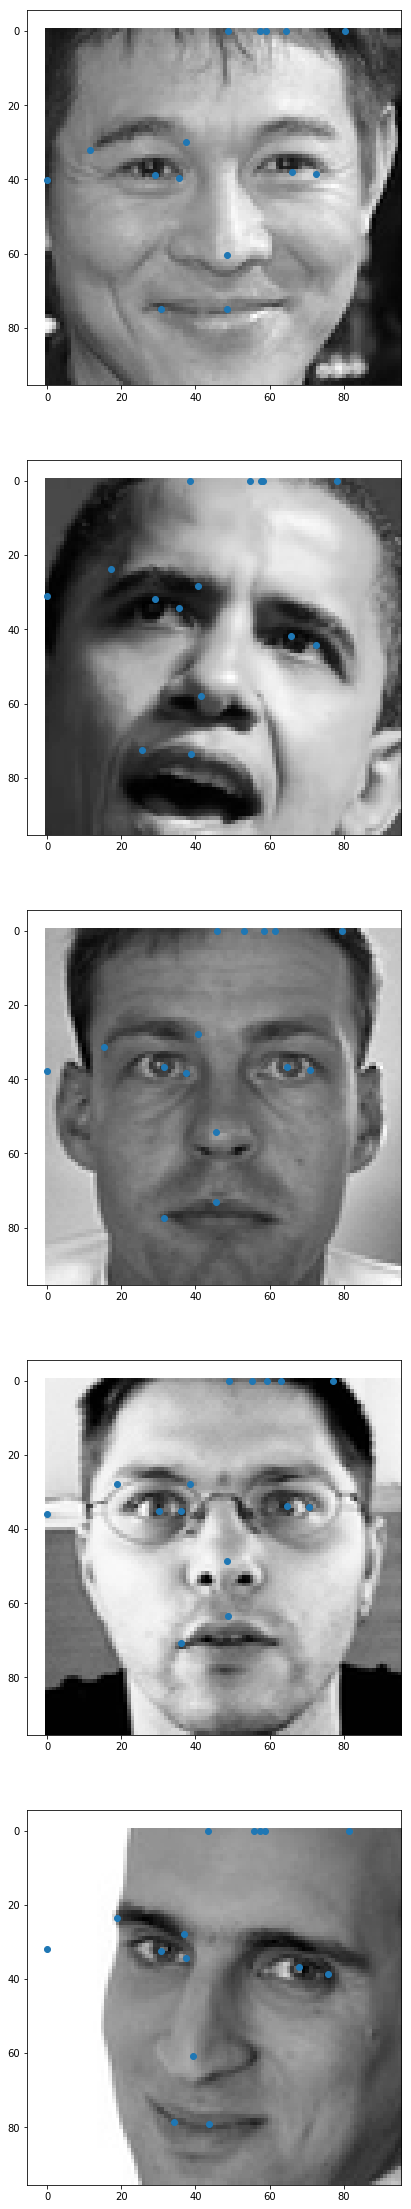

In [28]:
fig, axes = plt.subplots(len(predictions), 1, figsize=(8,8*len(predictions)))
axes = axes.flatten()
xs = predictions[:,0:30:2]
ys = predictions[:,1:30:2]
for i, ax in enumerate(axes):
    ax.imshow(np.reshape(X[-5+i],(96,96)), origin='upper', cmap='gray')
    ax.scatter(x=xs[i,:], y=ys[i,:])


In [32]:
def create_filter_cnn_model(start_filters=32):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filters, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filters*2, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filters*4, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
  
    return cnn_model

In [ ]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam,'sgd':sgd}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_filter_df = pd.DataFrame()

# Let's try a range of starting filter sizes from 3 to 16 (our baseline had 32)
n_filters = [3, 5, 12, 16]
for n in n_filters:
    for opt_name, opt in opt_list.items():
        model = create_filter_cnn_model(start_filters=n)
        model.compile(
              optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
        history = model.fit(
            X.astype(np.float32), y.astype(np.float32),
            epochs=200,
            validation_split=0.15, callbacks=[time_callback, early_stop])
        times = time_callback.times

        # Convert to dataframe
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        hist['RMSE'] = np.sqrt(hist.mean_squared_error)
        hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
        hist['times'] = times
        hist['starting_filter'] = n
        hist['layers'] = 3
        hist['pooling'] = 'yes'
        hist['fc_layer'] = 500
        hist['activation'] = 'relu'
        hist['optimizer'] = opt_name
        hist['lrate'] = opt.get_config()['learning_rate']

        # Keep concatenating to dataframe
        cnn_filter_df = pd.concat([cnn_filter_df,hist])

        # Re-pickle after every model to retain progress
        cnn_filter_df.to_pickle("OutputData/cnn_filter_df.pkl")

        # Save models.
        filename = "filter_cnn_model_{}_{}filters".format(opt_name, n)
        model.save("Models/"+filename+".h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 94, 94, 3)         30        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 47, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 6)         78        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 12)        300       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1452)             

1819/1819 [==============================] - 2s 1ms/sample - loss: 6.0632 - mean_squared_error: 6.0632 - val_loss: 6.2737 - val_mean_squared_error: 6.2737
Epoch 37/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 6.0540 - mean_squared_error: 6.0540 - val_loss: 6.7862 - val_mean_squared_error: 6.7862
Epoch 38/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 6.0144 - mean_squared_error: 6.0144 - val_loss: 5.9547 - val_mean_squared_error: 5.9547
Epoch 39/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 5.8032 - mean_squared_error: 5.8032 - val_loss: 5.8672 - val_mean_squared_error: 5.8672
Epoch 40/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 5.6799 - mean_squared_error: 5.6799 - val_loss: 5.7687 - val_mean_squared_error: 5.7687
Epoch 41/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 5.5644 - mean_squared_error: 5.5644 - val_loss: 5.7267 - val_mean_squared_error: 5.7267
Epoch

Epoch 85/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.4876 - mean_squared_error: 2.4876 - val_loss: 3.5072 - val_mean_squared_error: 3.5072
Epoch 86/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.4113 - mean_squared_error: 2.4113 - val_loss: 3.7545 - val_mean_squared_error: 3.7545
Epoch 87/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.3089 - mean_squared_error: 2.3089 - val_loss: 3.3849 - val_mean_squared_error: 3.3849
Epoch 88/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.4857 - mean_squared_error: 2.4857 - val_loss: 3.5103 - val_mean_squared_error: 3.5103
Epoch 89/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.3594 - mean_squared_error: 2.3594 - val_loss: 3.3016 - val_mean_squared_error: 3.3016
Epoch 90/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.2927 - mean_squared_error: 2.2927 - val_loss: 3.5252 - val_mean_squared_error:

1819/1819 [==============================] - 2s 1ms/sample - loss: 1.3814 - mean_squared_error: 1.3814 - val_loss: 3.1328 - val_mean_squared_error: 3.1328
Epoch 134/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.4055 - mean_squared_error: 1.4055 - val_loss: 3.0882 - val_mean_squared_error: 3.0882
Epoch 135/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.3848 - mean_squared_error: 1.3848 - val_loss: 3.2347 - val_mean_squared_error: 3.2347
Epoch 136/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.5267 - mean_squared_error: 1.5267 - val_loss: 3.0914 - val_mean_squared_error: 3.0914
Epoch 137/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.5202 - mean_squared_error: 1.5202 - val_loss: 3.0547 - val_mean_squared_error: 3.0547
Epoch 138/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.4053 - mean_squared_error: 1.4053 - val_loss: 3.2465 - val_mean_squared_error: 3.2465


1819/1819 [==============================] - 2s 1ms/sample - loss: 0.8882 - mean_squared_error: 0.8882 - val_loss: 3.0707 - val_mean_squared_error: 3.0707
Epoch 182/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.8087 - mean_squared_error: 0.8087 - val_loss: 3.0416 - val_mean_squared_error: 3.0416
Epoch 183/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.7892 - mean_squared_error: 0.7892 - val_loss: 3.2756 - val_mean_squared_error: 3.2756
Epoch 184/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.8630 - mean_squared_error: 0.8630 - val_loss: 3.0708 - val_mean_squared_error: 3.0708
Epoch 185/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.7692 - mean_squared_error: 0.7692 - val_loss: 3.0278 - val_mean_squared_error: 3.0278
Epoch 186/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.7665 - mean_squared_error: 0.7665 - val_loss: 3.1422 - val_mean_squared_error: 3.1422


Epoch 15/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1050.9138 - mean_squared_error: 1050.9138 - val_loss: 677.7497 - val_mean_squared_error: 677.7498
Epoch 16/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 473.3040 - mean_squared_error: 473.3041 - val_loss: 306.5498 - val_mean_squared_error: 306.5498
Epoch 17/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 216.2328 - mean_squared_error: 216.2328 - val_loss: 141.6104 - val_mean_squared_error: 141.6104
Epoch 18/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 101.8305 - mean_squared_error: 101.8305 - val_loss: 68.3015 - val_mean_squared_error: 68.3015
Epoch 19/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 50.9596 - mean_squared_error: 50.9596 - val_loss: 35.6806 - val_mean_squared_error: 35.6806
Epoch 20/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 28.3154 - mean_squared_error: 28.3154 - val_

Epoch 63/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1895 - mean_squared_error: 10.1895 - val_loss: 9.8837 - val_mean_squared_error: 9.8837
Epoch 64/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1891 - mean_squared_error: 10.1891 - val_loss: 9.8841 - val_mean_squared_error: 9.8841
Epoch 65/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1890 - mean_squared_error: 10.1890 - val_loss: 9.8840 - val_mean_squared_error: 9.8840
Epoch 66/200
1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1893 - mean_squared_error: 10.1893 - val_loss: 9.8829 - val_mean_squared_error: 9.8829
Epoch 67/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1892 - mean_squared_error: 10.1892 - val_loss: 9.8839 - val_mean_squared_error: 9.8839
Epoch 68/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1890 - mean_squared_error: 10.1890 - val_loss: 9.8845 - val_mean_sq

1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1890 - mean_squared_error: 10.1890 - val_loss: 9.8837 - val_mean_squared_error: 9.8837
Epoch 112/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1889 - mean_squared_error: 10.1889 - val_loss: 9.8842 - val_mean_squared_error: 9.8842
Epoch 113/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1893 - mean_squared_error: 10.1893 - val_loss: 9.8833 - val_mean_squared_error: 9.8833
Epoch 114/200
1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1892 - mean_squared_error: 10.1892 - val_loss: 9.8833 - val_mean_squared_error: 9.8833
Epoch 115/200
1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1888 - mean_squared_error: 10.1888 - val_loss: 9.8838 - val_mean_squared_error: 9.8838
Epoch 116/200
1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1891 - mean_squared_error: 10.1891 - val_loss: 9.8841 - val_mean_squared_er

1819/1819 [==============================] - 3s 2ms/sample - loss: 8.9140 - mean_squared_error: 8.9140 - val_loss: 8.7684 - val_mean_squared_error: 8.7684
Epoch 20/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.7044 - mean_squared_error: 8.7044 - val_loss: 8.9578 - val_mean_squared_error: 8.9578
Epoch 21/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.5022 - mean_squared_error: 8.5022 - val_loss: 8.5452 - val_mean_squared_error: 8.5452
Epoch 22/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.4160 - mean_squared_error: 8.4160 - val_loss: 8.5869 - val_mean_squared_error: 8.5869
Epoch 23/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.3058 - mean_squared_error: 8.3058 - val_loss: 8.1946 - val_mean_squared_error: 8.1946
Epoch 24/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.0228 - mean_squared_error: 8.0228 - val_loss: 8.4364 - val_mean_squared_error: 8.4364
Epoch

Epoch 68/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.8082 - mean_squared_error: 3.8082 - val_loss: 4.3932 - val_mean_squared_error: 4.3932
Epoch 69/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.8425 - mean_squared_error: 3.8425 - val_loss: 4.2441 - val_mean_squared_error: 4.2441
Epoch 70/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.6345 - mean_squared_error: 3.6345 - val_loss: 4.8376 - val_mean_squared_error: 4.8376
Epoch 71/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.7103 - mean_squared_error: 3.7103 - val_loss: 4.9922 - val_mean_squared_error: 4.9922
Epoch 72/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.6714 - mean_squared_error: 3.6714 - val_loss: 4.1341 - val_mean_squared_error: 4.1341
Epoch 73/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.5675 - mean_squared_error: 3.5675 - val_loss: 4.0222 - val_mean_squared_error:

Epoch 117/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2437 - mean_squared_error: 2.2437 - val_loss: 3.4887 - val_mean_squared_error: 3.4887
Epoch 118/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2471 - mean_squared_error: 2.2471 - val_loss: 3.4721 - val_mean_squared_error: 3.4721
Epoch 119/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2592 - mean_squared_error: 2.2592 - val_loss: 3.2886 - val_mean_squared_error: 3.2886
Epoch 120/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2032 - mean_squared_error: 2.2032 - val_loss: 3.1801 - val_mean_squared_error: 3.1801
Epoch 121/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.1056 - mean_squared_error: 2.1056 - val_loss: 3.2476 - val_mean_squared_error: 3.2476
Epoch 122/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.0628 - mean_squared_error: 2.0628 - val_loss: 3.1301 - val_mean_squared_

1819/1819 [==============================] - 4s 2ms/sample - loss: 1.4032 - mean_squared_error: 1.4032 - val_loss: 3.1899 - val_mean_squared_error: 3.1899
Epoch 166/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 1.3323 - mean_squared_error: 1.3323 - val_loss: 3.0060 - val_mean_squared_error: 3.0060
Epoch 167/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 1.3365 - mean_squared_error: 1.3365 - val_loss: 3.0077 - val_mean_squared_error: 3.0077
Epoch 168/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 1.3057 - mean_squared_error: 1.3057 - val_loss: 3.0532 - val_mean_squared_error: 3.0532
Epoch 169/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 1.3339 - mean_squared_error: 1.3339 - val_loss: 3.0125 - val_mean_squared_error: 3.0125
Epoch 170/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 1.3181 - mean_squared_error: 1.3181 - val_loss: 2.8841 - val_mean_squared_error: 2.8841


Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/200
1819/1819 [

1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 54/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 55/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 56/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 57/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 58/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 59/200
1819/1819 [==============================] - 3s 2ms/sample - los

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 752.3760 - mean_squared_error: 752.3762 - val_loss: 45.3117 - val_mean_squared_error: 45.3117
Epoch 2/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 18.7290 - mean_squared_error: 18.7290 - val_loss: 10.9340 - val_mean_squared_error: 10.9340
Epoch 3/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.8785 - mean_squared_error: 10.8785 - val_loss: 10.4603 - val_mean_squared_error: 10.4603
Epoch 4/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.6031 - mean_squared_error: 10.6031 - val_loss: 10.6460 - val_mean_squared_error: 10.6460
Epoch 5/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.4931 - mean_squared_error: 10.4931 - val_loss: 10.1670 - val_mean_squared_error: 10.1670
Epoch 6/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.4340 - mean_sq

1819/1819 [==============================] - 6s 3ms/sample - loss: 7.8840 - mean_squared_error: 7.8840 - val_loss: 7.8904 - val_mean_squared_error: 7.8904
Epoch 50/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.8295 - mean_squared_error: 7.8295 - val_loss: 7.7456 - val_mean_squared_error: 7.7456
Epoch 51/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.6741 - mean_squared_error: 7.6741 - val_loss: 7.6860 - val_mean_squared_error: 7.6860
Epoch 52/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.5684 - mean_squared_error: 7.5684 - val_loss: 7.5518 - val_mean_squared_error: 7.5518
Epoch 53/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.5160 - mean_squared_error: 7.5160 - val_loss: 7.7653 - val_mean_squared_error: 7.7653
Epoch 54/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.6505 - mean_squared_error: 7.6505 - val_loss: 8.0495 - val_mean_squared_error: 8.0495
Epoch